<a href="https://colab.research.google.com/github/Samjacob007/imdb-bert-/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np


In [3]:
!pip install --upgrade transformers datasets fsspec huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from datasets import load_dataset
import os
import shutil

cache_dir = os.path.expanduser("~/.cache/huggingface/datasets/imdb")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

# Now re-load the dataset
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# 3. Load tokenizer and tokenize text
from transformers import BertTokenizerFast
from datasets import load_dataset

# Assuming 'dataset' is already loaded in a previous cell
# If not, you might need to load it here or ensure the previous cell runs successfully first.
# Example if dataset is not loaded:
# dataset = load_dataset("imdb")


tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))  # use subset for faster training
test_dataset = tokenized_datasets["test"].select(range(1000))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:

# 4. Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 5. Define evaluation metric
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
# 6. Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",  # Disable Weights & Biases logging
)

In [12]:
# 7. Train the model using Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-12-2060216205.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.366900,0.463565,0.851000
2,0.229200,0.415659,0.894000


TrainOutput(global_step=1250, training_loss=0.2701625732421875, metrics={'train_runtime': 1017.7288, 'train_samples_per_second': 9.826, 'train_steps_per_second': 1.228, 'total_flos': 2631110553600000.0, 'train_loss': 0.2701625732421875, 'epoch': 2.0})

In [13]:
# Save the fine-tuned model and tokenizer
model_dir = "./bert-imdb-sentiment"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)
print(f"Model and tokenizer saved to {model_dir}")


Model and tokenizer saved to ./bert-imdb-sentiment


In [14]:
from transformers import BertTokenizerFast, BertForSequenceClassification

# Load the saved model and tokenizer
model_dir = "./bert-imdb-sentiment"
tokenizer = BertTokenizerFast.from_pretrained(model_dir)
model = BertForSequenceClassification.from_pretrained(model_dir)


In [15]:
# 8. Evaluate the model
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")

Test Accuracy: 0.8940


In [16]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return "Positive" if prediction == 1 else "Negative"

# Try example
print(predict_sentiment("This movie was absolutely fantastic!"))
print(predict_sentiment("I hated every minute of this movie."))


Positive
Negative


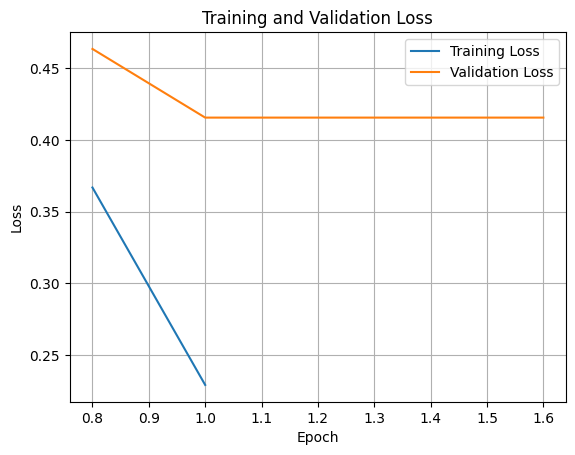

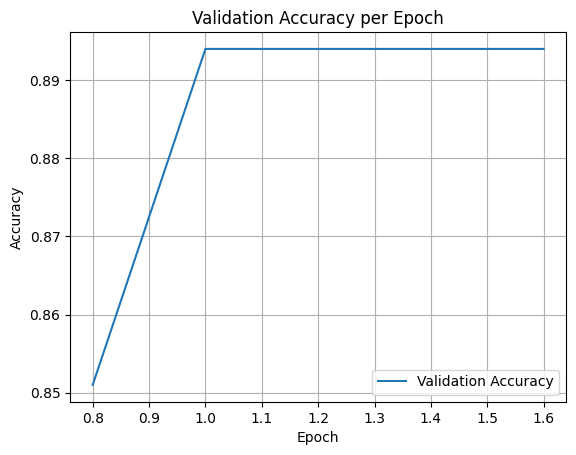

In [17]:
import matplotlib.pyplot as plt

# Access training logs from the trainer
history = trainer.state.log_history

# Extract values
epochs = []
train_loss = []
eval_loss = []
eval_acc = []

for log in history:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_acc.append(log['eval_accuracy'])

# Plot Loss
plt.figure()
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy (if available)
if eval_acc:
    plt.figure()
    plt.plot(epochs[:len(eval_acc)], eval_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()
